In [1]:
import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta
from ipython_helpers import (
    print_full
)
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
import readline
from IPython.display import display

In [52]:
GLOBAL_INPUT_VARIABLES = [
    'CASHMTA_win',
    'EXRET_AVG_win',
    'MB_win',
    'NIMTA_AVG_win',
    'RSIZE_win', 
    'PRICE_win',
    'SIGMA_win', 
    'TLMTA_win'    
]

def transform_data(df):
    if 'Unnamed: 0' in df:
        del df['Unnamed: 0']
    
    return df

    
def get_num_of_bankruptcy_df(df):
    df = df.drop_duplicates(subset=['PERMNO'], keep='first')
    bankruptcy_df = df[df['is_bankrupt'] == True]
    num_of_bankruptcy_series = bankruptcy_df.groupby(by=['deletion_year']).count()['is_bankrupt']
    num_of_bankruptcy_df = pd.DataFrame(num_of_bankruptcy_series)
    num_of_bankruptcy_df.rename(columns={'is_bankrupt': 'Bankruptcies'}, inplace=True)
    num_of_bankruptcy_df.index = num_of_bankruptcy_df.index.astype(np.int32)

    return num_of_bankruptcy_df
    
    
def get_num_of_active_firms_df(df):  
    df = df.drop_duplicates(subset=['PERMNO', 'year'], keep='first')
    num_of_active_firms_series = df.groupby(by=['year']).count()['PERMNO']
    num_of_active_firms_df = pd.DataFrame(num_of_active_firms_series)
    num_of_active_firms_df.rename(columns={'PERMNO': 'Active Firms'}, inplace=True)
    
    return num_of_active_firms_df


def get_firm_status_by_year(df):
    num_of_active_firms_df = get_num_of_active_firms_df(df)
    num_of_bankruptcy_df = get_num_of_bankruptcy_df(df)

    df = num_of_active_firms_df.merge(num_of_bankruptcy_df, how='left', left_index=True, right_index=True)
    df.reset_index(inplace=True)
    df.rename(
        columns={
            'year': 'Year',
        },
        inplace=True
    )
    df.reset_index(inplace=True)
    df['(%)'] =(df['Bankruptcies'] / df['Active Firms'] * 100).round(4)
    df = df[['Year', 'Active Firms', 'Bankruptcies', '(%)']]

    return df


def get_observations_by_columns(df):
    input_df = df[['PERMNO', 'NIMTA_AVG_win', 'TLMTA_win', 'CASHMTA_win', 'RSIZE_win', 'PRICE_win', 'EXRET_AVG_win', 'SIGMA_win', 'MB_win']]
    
    observations_by_columns_df = pd.DataFrame(input_df.count(axis=0), columns=['Num of Observatons'])
                                    
    return observations_by_columns_df    


def get_observations_by_num_of_vars(df):
    input_df = df[['PERMNO', 'NIMTA_AVG_win', 'TLMTA_win', 'CASHMTA_win', 'RSIZE_win', 'PRICE_win', 'EXRET_AVG_win', 'SIGMA_win', 'MB_win']]

    num_of_vars_df = pd.DataFrame(pd.DataFrame(input_df.count(axis=1), columns=['Num of Observations']))
    observations_by_num_of_vars_df = pd.DataFrame(num_of_vars_df['Num of Observations'].value_counts(), columns=['Num of Observations'])
    
    return observations_by_num_of_vars_df.sort_index(ascending=False)
        

def compute_months_diff(row):
    year_diff = row['deletion_year'] - row['year']
    months_diff = row['deletion_month'] - row['month']
    
    if year_diff > 0:
        return 12 * year_diff + months_diff 
    else:
        return months_diff 

    
def make_months_diff_df(df, find_closest=False):
    bankruptcy_df = df[df['is_bankrupt'] == True]
    bankruptcy_df = bankruptcy_df.sort_values(by=['PERMNO', 'year', 'month'])
    if find_closest:
        bankruptcy_df.drop_duplicates(subset=['PERMNO'], keep='last', inplace=True)

    bankruptcy_df.loc[:, 'months_diff'] = bankruptcy_df.apply(lambda x: compute_months_diff(x), axis=1)
    
    return bankruptcy_df 


def filter_months_diff_df(df, threshold_diff):

    closest_months_diff_df = make_months_diff_df(df, find_closest=True)
    large_months_diff_df = closest_months_diff_df[closest_months_diff_df['months_diff'] > threshold_diff]
    security_filter_1 = large_months_diff_df['PERMNO'].values

    months_diff_df = make_months_diff_df(df)
    small_months_diff_df = months_diff_df[months_diff_df['months_diff'] < threshold_diff]
    index_filter = small_months_diff_df.index 
    
    output_df = df[~df['PERMNO'].isin(security_filter_1)]
    output_df = output_df.drop(index_filter) 
    
    bankruptcy_list_all = output_df[output_df['is_bankrupt'] == True]['PERMNO'].unique()
    bankruptcy_list_specific = output_df[output_df['is_bankrupt_12'] == True]['PERMNO'].unique()
    diff_list = list(set(bankruptcy_list_all).symmetric_difference(set(bankruptcy_list_specific)))
    
    output_df = output_df[~output_df['PERMNO'].isin(diff_list)]
    
    return output_df
        
    
def plot_histogram_of_diff_in_dates(df):
    max_num = df['months_diff'].max() + 1
    df['months_diff'].hist(bins=max_num + 1, range=(0, max_num))

    return 
    
def get_complete_features(df):
    df = df.dropna(how='any', subset=GLOBAL_INPUT_VARIABLES)
    
    return df


def filter_year_df(df, start_year=1970, end_year=2015):
    return df[(df['year'] >= start_year) & (df['year'] <= end_year)]


def make_train_and_test_df(df, threshold_year=2005):
    train_df = df[df['year'] <= threshold_year]
    test_df = df[df['year'] > threshold_year]
    
    return train_df, test_df


def get_num_of_bankruptcies(df):
    return len(df[df['is_bankrupt'] == True]['PERMNO'].unique())


def remove_bankrupt_observations_with_missing_24_months(df):
    """Remove observations where "is_bankrupt" is marked as True
    but "is_bankrupt_within_24" is marked as False.
    This removal is necessary because while the bankrupt observations have
    features that are indicative of bankrupcy, the False mark for "is_bankrupt_within_12"
    would confuse the model.
    """
    bankrupty_df = df[df['is_bankrupt'] == True]
    all_list = bankruptcy_df['PERMNO'].unique()
    available_list = bankruptcy_df[bankruptcy_df['is_bankrupt_within_24'] == True]['PERMNO'].unique()
    missing_list = list(set(all_list).symmetric_difference(set(available_list)))
    
    return df[~df['PERMNO'].isin(missing_list)]


def get_last_observation_df(df):
    df = df[df['is_bankrupt'] == True]
    df = df.sort_values(by=['PERMNO', 'year', 'month'])
    df = df.drop_duplicates(subset=['PERMNO'], keep='last')

    return df

In [3]:
original_df = pd.read_csv("../../../../Development/econ985/campbell_data/simple_annual_campbell_df_24.csv", parse_dates=['datadate', 'lagged_date', 'dldte'])

In [4]:
transformed_df = transform_data(original_df)

In [60]:
filtered_year_df = filter_year_df(transformed_df, start_year=1970, end_year=2014)
get_firm_status_by_year(filtered_year_df)

,Year,Active Firms,Bankruptcies,(%)
0,1970,1918,NaN,NaN
1,1971,2014,2.0,0.0993
2,1972,2113,3.0,0.1420
3,1973,2471,7.0,0.2833
4,1974,2484,4.0,0.1610
5,1975,2486,6.0,0.2414
6,1976,2468,12.0,0.4862
7,1977,2437,6.0,0.2462
8,1978,2378,13.0,0.5467
9,1979,2321,14.0,0.6032


In [39]:
complete_df = get_complete_features(filtered_year_df)

In [40]:
print(filtered_year_df.shape)
print(get_num_of_bankruptcies(filtered_year_df))
print(filtered_year_df[filtered_year_df['is_bankrupt_within_24'] == True].shape)
print(complete_df.shape)
print(get_num_of_bankruptcies(complete_df))
print(complete_df[complete_df['is_bankrupt_within_24'] == True].shape)

(197225, 20)
1222
(830, 20)
(172815, 20)
1159
(697, 20)


count    1159.000000
mean       34.188093
std        36.753450
min         3.000000
25%        18.000000
50%        22.000000
75%        34.000000
max       358.000000
Name: month_diff, dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12083c150>]], dtype=object)

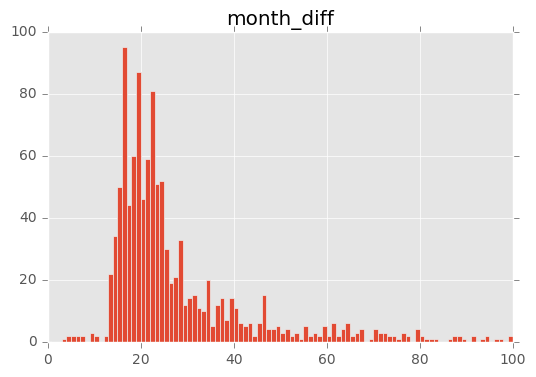

In [41]:
bankruptcy_df = get_last_observation_df(complete_df)
print(bankruptcy_df['month_diff'].describe())
bankruptcy_df.hist(column=['month_diff'], range=[0, 100], bins=100)

In [58]:
complete_df1 = remove_bankrupt_observations_with_missing_24_months(complete_df)

In [59]:
get_firm_status_by_year(complete_df1)

,Year,Active Firms,Bankruptcies,(%)
0,1971,216,NaN,NaN
1,1972,234,NaN,NaN
2,1973,288,NaN,NaN
3,1974,334,NaN,NaN
4,1975,1281,NaN,NaN
5,1976,2102,1.0,0.0476
6,1977,2232,5.0,0.2240
7,1978,2188,9.0,0.4113
8,1979,2123,13.0,0.6123
9,1980,2041,12.0,0.5879


In [62]:
filtered_year_df1 = filter_year_df(complete_df1, start_year=1976, end_year=2014)

In [63]:
get_firm_status_by_year(filtered_year_df1)

,Year,Active Firms,Bankruptcies,(%)
0,1976,2102,NaN,NaN
1,1977,2232,1.0,0.0448
2,1978,2188,9.0,0.4113
3,1979,2123,13.0,0.6123
4,1980,2041,12.0,0.5879
5,1981,2208,6.0,0.2717
6,1982,3712,8.0,0.2155
7,1983,4054,7.0,0.1727
8,1984,4421,9.0,0.2036
9,1985,4331,15.0,0.3463


In [66]:
train_df_24, test_df_24 = make_train_and_test_df(filtered_year_df1)

# Save Data

In [67]:
train_df_24.to_csv("../../../../Development/econ985/campbell_data/train_df_annual_24.csv")
test_df_24.to_csv("../../../../Development/econ985/campbell_data/test_df_annual_24.csv")

In [68]:
observations = filtered_year_df1.shape[0]
num_bankruptcies = filtered_year_df1[filtered_year_df1['is_bankrupt_within_24'] == True].shape[0]
print(observations, num_bankruptcies, float(num_bankruptcies)/observations * 100)

(166996, 692, 0.4143811827828211)


In [ ]:
observations = filtered_year_df1.shape[0]
num_bankruptcies = filtered_year_df1[filtered_year_df1['is_bankrupt_within_24'] == True].shape[0]
print(observations, num_bankruptcies, float(num_bankruptcies)/observations * 100)

In [69]:
df = train_df_24
observations = df.shape[0]
num_bankruptcies = df[df['is_bankrupt_within_24'] == True].shape[0]
print(observations, num_bankruptcies, float(num_bankruptcies)/observations * 100)

(131451, 618, 0.4701371613757217)


In [70]:
df = test_df_24
observations = df.shape[0]
num_bankruptcies = df[df['is_bankrupt_within_24'] == True].shape[0]
print(observations, num_bankruptcies, float(num_bankruptcies)/observations * 100)

(35545, 74, 0.20818680545787027)
